# **モデリングのためのデータ変換**

**データの不均衡度や分布の確認**

9.1 キャンペーンデータの読み込み

In [1]:
# campaign.csvデータを読み込み
import pandas as pd
campaign = pd.read_csv('campaign.csv', dtype={'customer_id': str})

# campainデータの確認
campaign.head()

,customer_id,campaign_a,campaign_b,campaign_c,age,gender,campaignb_purchase_amount
0,35660,False,False,False,46,1,24700
1,52780,False,False,False,54,1,40300
2,23790,False,False,False,22,1,10100
3,17961,False,False,False,37,1,23100
4,30623,False,False,False,29,1,11400


9.2 クラス分布の確認

In [2]:
# campaign_bのクラス分布を確認。T/Fを確認します。
# 可視化も行いたいのでここでインポートしておきましょう。
# 視化のライブラリをインポート
import matplotlib.pyplot as plt
import seaborn as sns

#キャンペーンBのTrue/Falseの件数を集計
campaign_b_counts = campaign['campaign_b'].value_counts()
campaign_b_counts

,count
campaign_b,
False,16766
True,157


9.3 グラフ描画

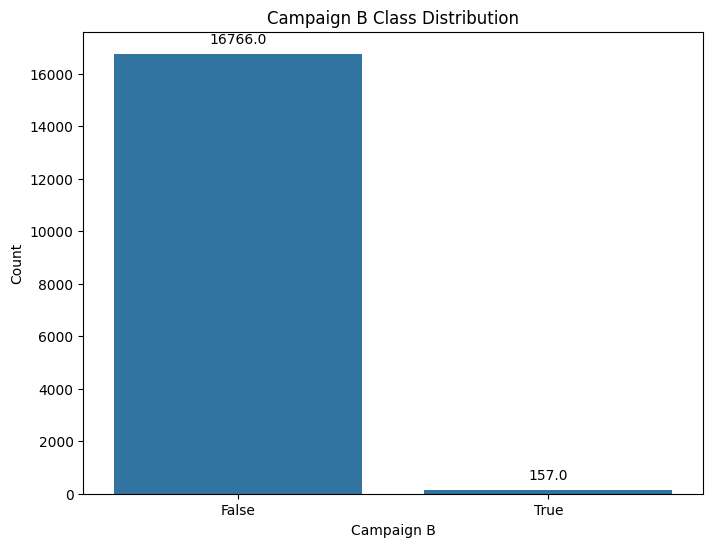

In [3]:
# 可視化も行うように心がけておきましょう
# グラフを描画
plt.figure(figsize=(8, 6))
sns.countplot(x='campaign_b', data=campaign)

#棒グラフの上に件数を表示
for p in plt.gca().patches:
   plt.gca().annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Campaign B Class Distribution')
plt.xlabel('Campaign B')
plt.ylabel('Count')

plt.show()

9.4 クラスの重み付けと機械学習

In [4]:
# 重み付け処理の追加部分
# xgboostのインポート
from xgboost import XGBClassifier
# 機械学習のデータ分割のインポートを追加
from sklearn.model_selection import train_test_split

# クラスの件数をカウント
count_negative = (campaign["campaign_b"] == False).sum()
count_positive = (campaign["campaign_b"] == True).sum()

# 重みの計算
scale_pos_weight = count_negative / count_positive

# 特徴量とターゲットに分割（customer_idを除外）
X = campaign.drop(columns=["customer_id", "campaign_b"])
y = campaign["campaign_b"]

# 学習用・テスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル学習
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

9.5 年齢分布の確認

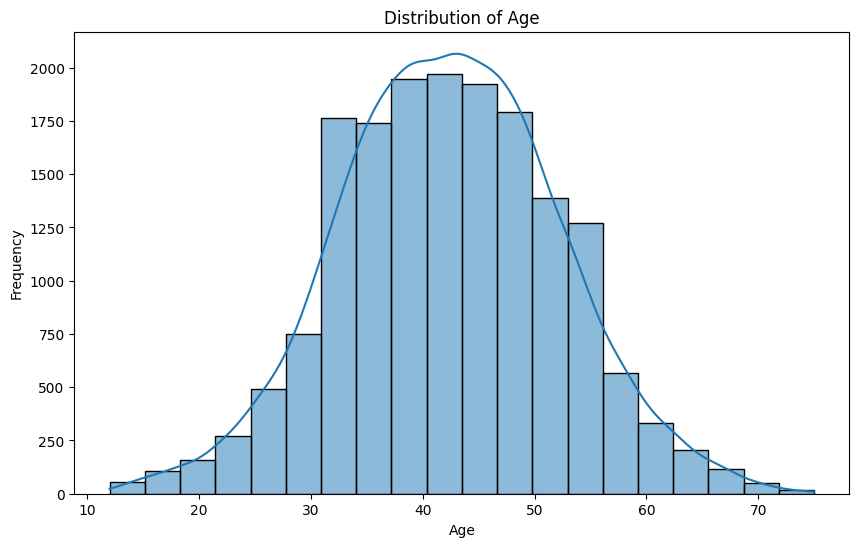

In [5]:
# campaignデータのage、gender、campaignb_purchese_amountの分布をそれぞれ確認します。
# まずはageの分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(campaign['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


9.6 性別の分布の確認

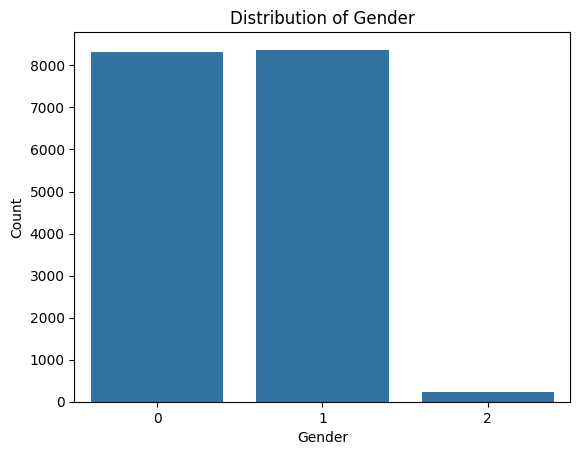

In [6]:
# genderの分布を確認
sns.countplot(x='gender', data=campaign)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

9.7 キャンペーン利用での決済金額の分布の確認

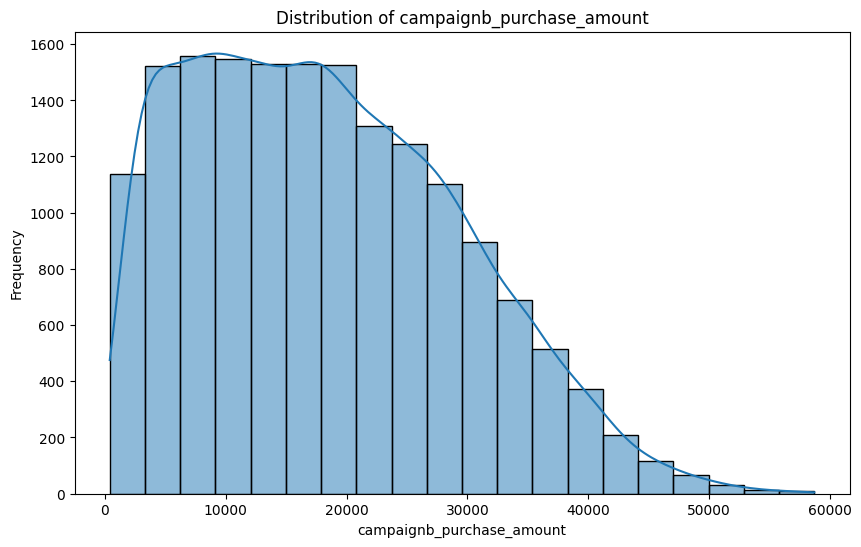

In [7]:
# campaign_b_purchase_amountの分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(campaign['campaignb_purchase_amount'], bins=20, kde=True)
plt.title('Distribution of campaignb_purchase_amount')
plt.xlabel('campaignb_purchase_amount')
plt.ylabel('Frequency')
plt.show()

**生成系モデルの活用**

9.8 CTGANを用いたデータの生成

In [8]:
  # CTGANSynthesizerを用いて、campaignデータのデータを増やす生成を実行
  # まずはじめにCTGANをインストール
  !pip install ctgan

  # データ合成用ライブラリSDV（Synthetic Data Vault）をインストール
  !pip install sdv

  # 必要なライブラリとインストールしたCTGANの呼び出し
  from sdv.single_table import CTGANSynthesizer
  from sdv.metadata import SingleTableMetadata

  # 欠損値のチェックと除外
  print("欠損値のある列と件数:\n", campaign.isnull().sum())
  campaign = campaign.dropna()
  print(f"\n欠損値除外後のデータ件数: {len(campaign)}")

  # 合成データ生成に必要なメタデータ（各列の型情報など）を定義するオブジェクトを作成
  metadata = SingleTableMetadata()

  # campaign というデータフレームのメタデータ（データの構造や型の情報）を自動的に検出
  metadata.detect_from_dataframe(data=campaign)
  metadata = SingleTableMetadata()
  metadata.detect_from_dataframe(data=campaign)

  # customer_idをカテゴリ変数として扱うよう指定
  metadata.update_column(column_name='customer_id', sdtype='categorical')

  # CTGANSynthesizerのインスタンスを作成, epochsはここで指定します
  ctgan = CTGANSynthesizer(metadata, epochs=50)

  # モデル（CTGAN）にデータを学習させる
  ctgan.fit(campaign)

  # 新しいデータを生成する（元のデータの2倍の量を生成する例）
  synthetic_data = ctgan.sample(campaign.shape[0] * 2)

  # 元のデータと合成データを結合
  combined_data = pd.concat([campaign, synthetic_data], ignore_index=True)

  # 結合したデータの確認
  combined_data.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:163: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:129: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


,customer_id,campaign_a,campaign_b,campaign_c,age,gender,campaignb_purchase_amount
0,35660,False,False,False,46,1,24700
1,52780,False,False,False,54,1,40300
2,23790,False,False,False,22,1,10100
3,17961,False,False,False,37,1,23100
4,30623,False,False,False,29,1,11400


9.9 生成されたデータの分布の確認

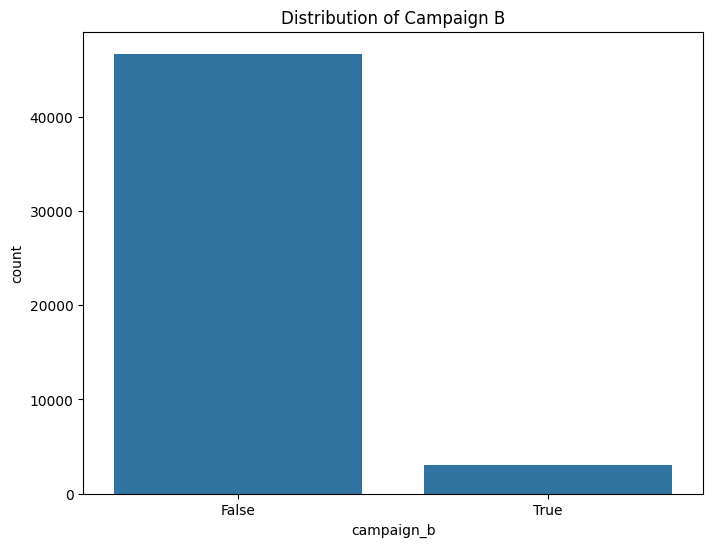

In [13]:
# combined_data を使用: campaign_b，age，gender，campaignb_purchase_amountの分布をそれぞれ描画して確認します

# 生成して作成したcombined_data を使用
import matplotlib.pyplot as plt
import seaborn as sns

# campaignbの分布
plt.figure(figsize=(8, 6))
sns.countplot(x='campaign_b', data=combined_data)
plt.title('Distribution of Campaign B')
plt.show()

プログラムリスト 9.9 生成されたデータの分布の確認

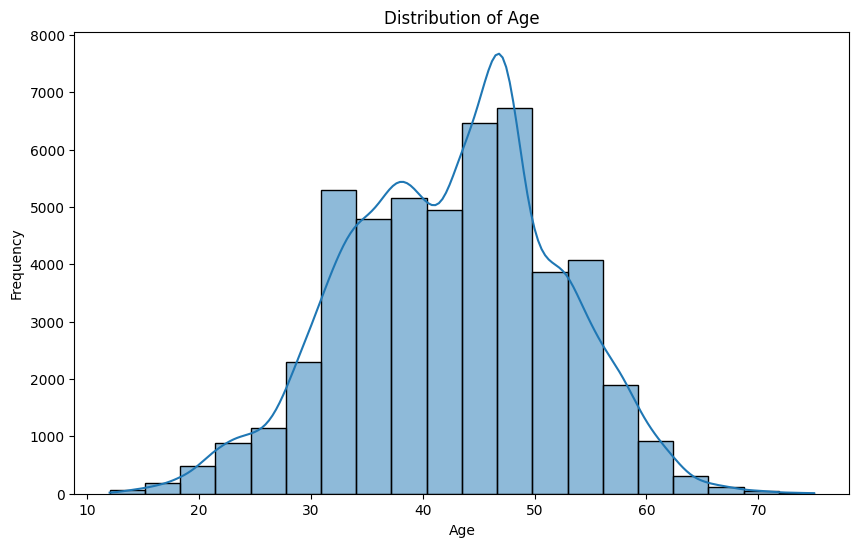

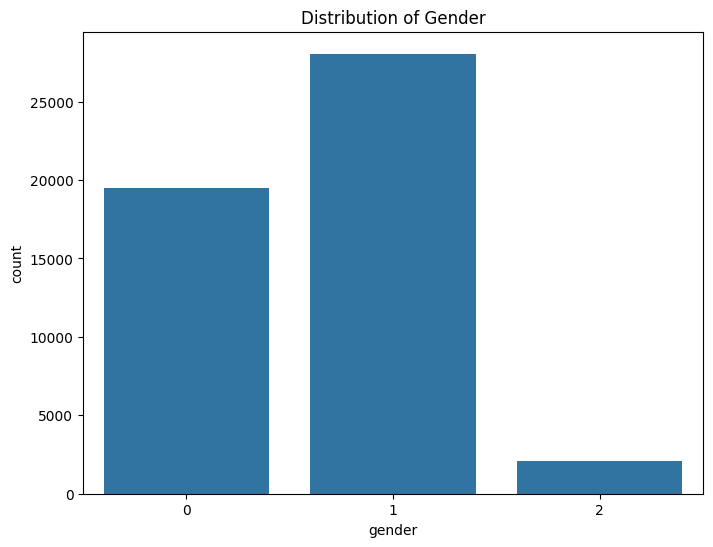

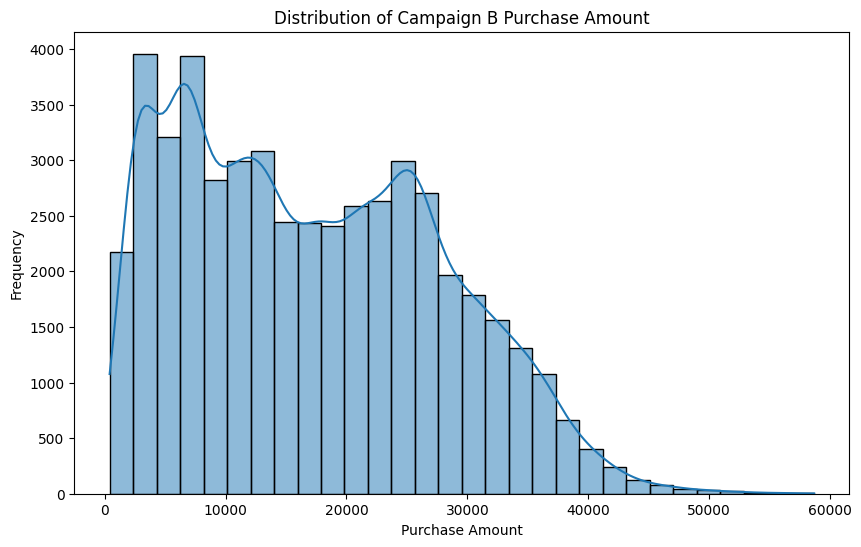

In [14]:
# 年齢(age)の分布
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 性別(gender)の分布
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=combined_data)
plt.title('Distribution of Gender')
plt.show()

# campaign_b利用での決済金額(campaign_b_purchase_amount)の分布
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['campaignb_purchase_amount'], bins=30, kde=True)
plt.title('Distribution of Campaign B Purchase Amount')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

9.11 EPOC 数を上げた場合の CTGAN でのデータ生成

In [ ]:
# 乱数シードの固定（再現性の確保）
import numpy as np
import torch

np.random.seed(8)
torch.manual_seed(8) # seedのあとの()内の数字が乱数シードの値

# Epochs数を増やした場合（例としてEpochs数を55に設定）
# CTGANSynthesizerのインスタンスを作成, epochsはここで指定します
ctgan = CTGANSynthesizer(metadata, epochs=70)

# データを学習させる
ctgan.fit(campaign)

# 新しいデータを生成する（元のデータの2倍の量を生成する例）
synthetic_data2 = ctgan.sample(campaign.shape[0] * 2)

# 元のデータと合成データを結合
combined_data2 = pd.concat([campaign, synthetic_data2], ignore_index=True)

# 結合したデータの確認
combined_data2

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:162: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


PerformanceAlert: Using the CTGANSynthesizer on this data is not recommended. To model this data, CTGAN will generate a large number of columns.

Original Column Name      Est # of Columns (CTGAN)
customer_id               4849
campaign_a                2
campaign_b                2
campaign_c                2
age                       11
gender                    3
campaignb_purchase_amount 11

We recommend preprocessing discrete columns that can have many values, using 'update_transformers'. Or you may drop columns that are not necessary to model. (Exit this script using ctrl-C)


,customer_id,campaign_a,campaign_b,campaign_c,age,gender,campaignb_purchase_amount
0,35660,False,False,False,46,1,24700
1,52780,False,False,False,54,1,40300
2,23790,False,False,False,22,1,10100
3,17961,False,False,False,37,1,23100
4,30623,False,False,False,29,1,11400
...,...,...,...,...,...,...,...
49684,54851,False,False,False,40,1,21143
49685,23956,False,True,False,52,0,24968
49686,15151,False,True,False,30,1,11246
49687,12665,False,False,True,54,1,28364


 9.12 EPOC 数を上げた場合の分布の確認

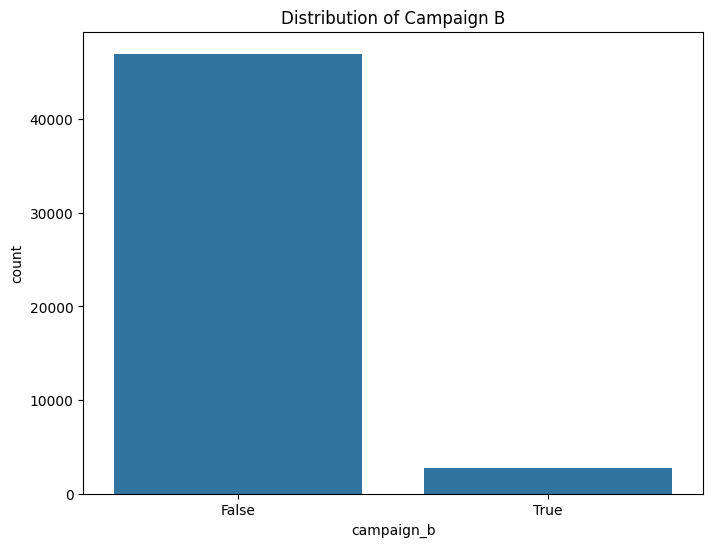

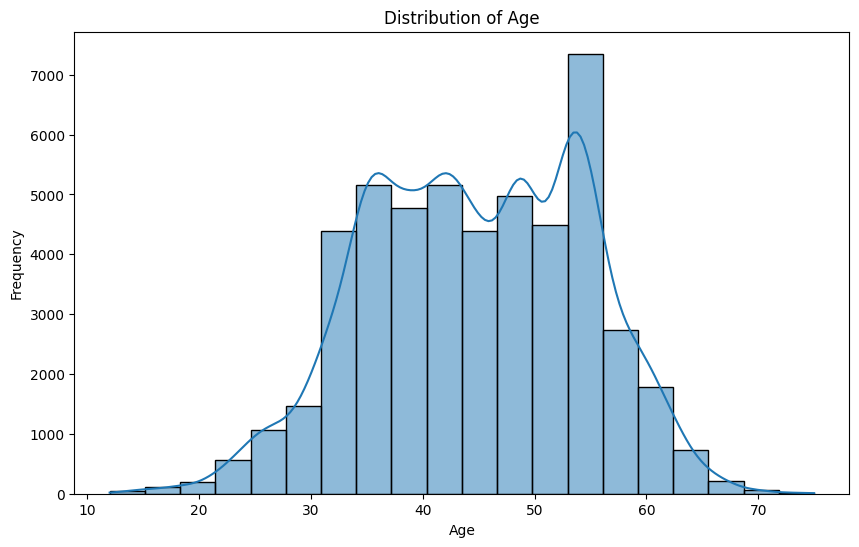

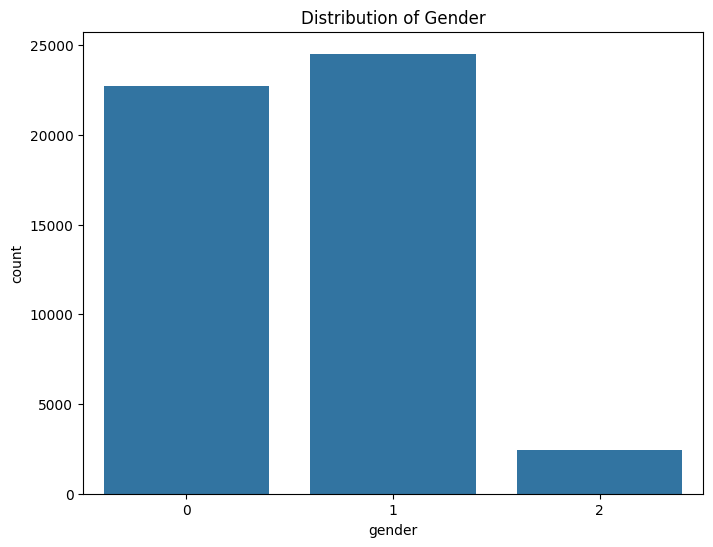

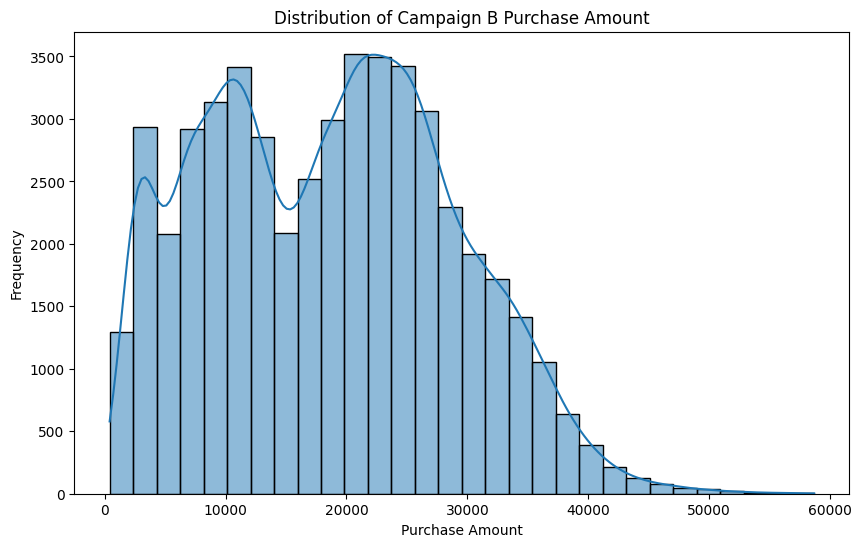

In [ ]:
# campaign_b、age、gender、campaignb_purchase_amountの分布をそれぞれ描画して確認します
# 生成して作成したcombined_data2 を使用

import matplotlib.pyplot as plt
import seaborn as sns

#キャンペーンBの分布
plt.figure(figsize=(8, 6))
sns.countplot(x='campaign_b', data=combined_data2)
plt.title('Distribution of Campaign B')
plt.show()

#年齢ageの分布
plt.figure(figsize=(10, 6))
sns.histplot(combined_data2['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

#性別の分布
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=combined_data2)
plt.title('Distribution of Gender')
plt.show()

#キャンペーンBの購入額の分布
plt.figure(figsize=(10, 6))
sns.histplot(combined_data2['campaignb_purchase_amount'], bins=30, kde=True)
plt.title('Distribution of Campaign B Purchase Amount')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

9.13 Gaussian Copulaでのデータ生成

In [ ]:
#必要なライブラリをインストールします。
!pip install pandas numpy matplotlib copulas

In [ ]:
#Copulas ライブラリの GaussianMultivariateをインポート
import pandas as pd
from copulas.multivariate import GaussianMultivariate

In [ ]:
# Gaussian Copulaモデルの適用
# campaignデータから数値型のカラムのみを選択（Gaussian Copulaは連続変数を扱うものであるため）

# 特定のカラム（age と campaignb_purchase_amount）›のみを選択する場合は下記を実行
numerical_campaign = campaign[['age', 'campaignb_purchase_amount']]
numerical_campaign

,age,campaignb_purchase_amount
0,46,24700
1,54,40300
2,22,10100
3,37,23100
4,29,11400
...,...,...
16918,37,22200
16919,38,8300
16920,22,11800
16921,44,4800


9.14 Copulaを用いた数値型のデータのみ生成

In [ ]:
# Gaussian Copulaモデルの適用
copula = GaussianMultivariate()

# 数値型のデータのみでcopulaを学習
copula.fit(numerical_campaign)

# 新しいデータの生成
num_samples = 1000
generated_data = copula.sample(num_samples)

# 生成されたデータはnumerical_campaignの列名を持つようにする
generated_numerical_campaign = pd.DataFrame(generated_data, columns=numerical_campaign.columns)

# 生成したデータの分布の把握 (数値型のカラムのみ)
print("Generated Data Summary:")
generated_numerical_campaign.describe()

Generated Data Summary:


,age,campaignb_purchase_amount
count,1000.000000,1000.000000
mean,42.490147,18339.706762
std,9.868974,11185.388008
min,13.118312,410.999846
25%,35.696717,9338.911867
50%,42.956623,17068.330732
75%,49.590494,25890.763316
max,71.659172,54589.818296


9.15 Gaussian Copulaで生成したデータの分布の確認

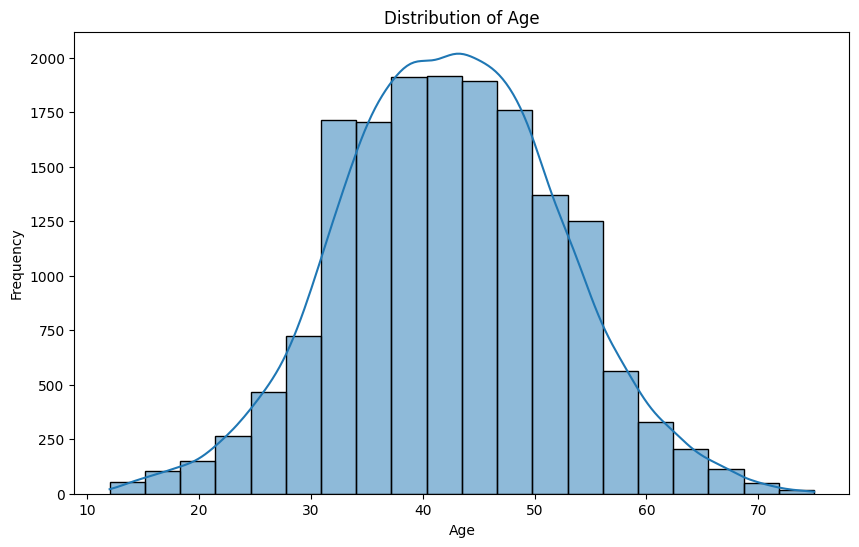

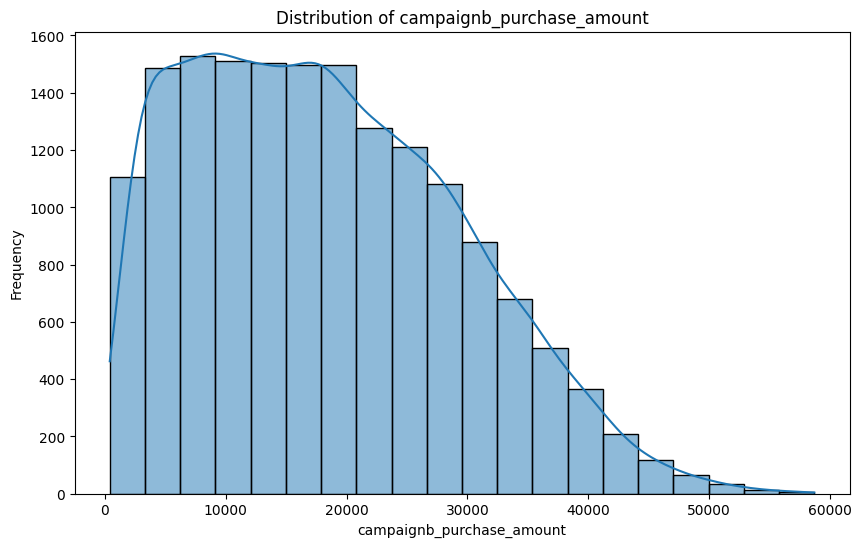

In [ ]:
# ageとcampaignb_purchase_amountのヒストグラムを確認

# ageのヒストグラム
plt.figure(figsize=(10, 6))
sns.histplot(campaign['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# campaignb_purchase_amountのヒストグラム
plt.figure(figsize=(10, 6))
sns.histplot(campaign['campaignb_purchase_amount'], bins=20, kde=True)
plt.title('Distribution of campaignb_purchase_amount')
plt.xlabel('campaignb_purchase_amount')
plt.ylabel('Frequency')
plt.show()

9.16 データの件数の確認

In [19]:
# データの読み込み
import pandas as pd
transaction_history = pd.read_csv('transaction_history.csv', dtype={'customer_id': str})   # 顧客の購入履歴データ
product_master = pd.read_csv('product_master.csv', dtype={'customer_id': str})   # 商品マスターのデータ

9.17 巨大なデータになってしまいそうなので、transaction_historyのcustomer_idの件数とproduct_masterのproduct_idの数を確認


In [20]:
# 顧客IDのユニーク件数
customer_count = transaction_history['customer_id'].nunique()
print(f'顧客IDのユニーク件数: {customer_count}')

# 商品IDのユニークな件数
product_count = product_master['product_id'].nunique()
print(f'商品IDのユニーク件数: {product_count}')

顧客IDのユニーク件数: 277235
商品IDのユニーク件数: 200000


9.18 データの結合

In [21]:
#  transaction_historyとproduct_masterをproduct_idをキーにInnner JoIN結合したデータを作成
import pandas as pd

# transaction_historyとproduct_masterをproduct_idをキーにInner Join結合
merged_data = pd.merge(transaction_history, product_master, on='product_id', how='inner')

# 結合結果の確認
merged_data.head()

,customer_id,product_id,purchase_date,purchase_amount,redeem_coupon,final_settlement_amount,payment_method,purchase_channel,product_name,product_type,price,departure_city,destination_city,register_date,description
0,00023085,G03257PD,2020/3/13,7200,True,6200.0,現金,2.0,サクラエアライン 東京 → バンコク 航空券（ビジネスクラス）,6,514000.0,東京,バンコク,2020/7/14,東京からバンコクまで、サクラエアラインのビジネスクラスで快適な空の旅を。上質なサービスで特別...
1,00015469,CKZF21ZC,2023/3/29,15400,False,NaN,カード,2.0,魅惑のローマ 6日間ツアー,3,195000.0,東京,ローマ,2023/3/13,ローマの魅力を存分に楽しめる6日間のツアー。魅惑の体験を満喫し、心に残る旅を。
2,00015482,7NSE0G0R,2023/12/26,15400,False,NaN,現金,1.0,ふじヴィラ（熊本）宿泊,5,13200.0,NaN,熊本,2020/3/26,ふじヴィラ（熊本）宿泊への滞在手配です。ふじヴィラ（熊本）宿泊で贅沢な時間を
3,00017107,WVCPYZBH,2021/2/19,17100,False,NaN,カード,2.0,夢のようなの香港 4日間ツアー,3,175000.0,大阪,香港,2020/8/31,香港の魅力を存分に楽しめる4日間のツアー。夢のようなな体験を満喫し、心に残る旅を。
4,00024156,OELTJ7E2,2020/10/8,24100,True,23100.0,カード,1.0,魅惑のドバイ 5日間ツアー,3,374000.0,東京,ドバイ,2020/2/5,ドバイの魅力を存分に楽しめる5日間のツアー。魅惑の体験を満喫し、心に残る旅を。


9.19 結合したデータの商品ID件数の確認

In [22]:
# 作成したmerged_dataのproduct_idのユニーク件数を確認
# merged_dataのproduct_idのユニーク件数を確認
unique_product_count = merged_data['product_id'].nunique()
print(f'merged_dataのproduct_idのユニーク件数: {unique_product_count}')

merged_dataのproduct_idのユニーク件数: 61992


9.20 クロス集計表の実装方法

In [ ]:
# customer_idごとにproduct_idの購入件数をカウント
customer_product_counts = merged_data.groupby('customer_id')['product_id'].value_counts().unstack(fill_value=0)

# 結果の表示
# customer_product_counts.head()

<ipython-input-6-1bd0aed44823>:2: PerformanceWarning: The following operation may generate 10430711928 cells in the resulting pandas object.
  customer_product_counts = merged_data.groupby('customer_id')['product_id'].value_counts().unstack(fill_value=0)


9.21 商品IDの情報を変換

In [24]:
# merged_data からcustomer_idとdestination_cityを抽出
customer_destination = merged_data[['customer_id', 'destination_city']]

# 結果の表示
customer_destination.head()

,customer_id,destination_city
0,00023085,バンコク
1,00015469,ローマ
2,00015482,熊本
3,00017107,香港
4,00024156,ドバイ


9.22 クロス集計

In [25]:
# customer_idごとのdestination_cityをcustomer_idを見出しとしてクロス集計
customer_destination_counts = customer_destination.groupby('customer_id')['destination_city'].value_counts().unstack(fill_value=0)

# 結果の表示
customer_destination_counts

destination_city,シドニー,シンガポール,ソウル,ドバイ,ニューヨーク,バンコク,パリ,ロンドン,ローマ,函館,...,旭川,松山,熊本,秋田,那覇,長崎,青森,静岡,香港,高松
customer_id,,,,,,,,,,,,,,,,,,,,,
00010000,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00010001,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
00010002,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00010003,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00010004,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00287179,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00287188,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00287203,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**スパース変換**

9.23 スパースモデリング

In [26]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

In [27]:
# customer_id と product_id をカテゴリ型に変換（メモリ削減）
customer_ids = transaction_history['customer_id'].astype('category')
product_ids = transaction_history['product_id'].astype('category')

In [28]:
# スパース行列の行・列インデックスを取得（カテゴリを数値に変換）
row = customer_ids.cat.codes.values  # customer_id を数値に変換
col = product_ids.cat.codes.values  # product_id を数値に変換
data = np.ones(len(transaction_history))  # 各購入履歴のカウントを1とする

In [29]:
# スパース行列を作成
sparse_matrix = coo_matrix((data, (row, col)), shape=(len(customer_ids.cat.categories), len(product_ids.cat.categories)))

In [30]:
# CSR形式に変換（行方向の圧縮でより高速処理が可能）
sparse_matrix = sparse_matrix.tocsr()
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 395080 stored elements and shape (277235, 200989)>